## PCA

* Os dados originais foram rotacionados por um ângulo de 45º uma vez que os auto-vetores são perpendiculares e obtidos dos eixos x e y por uma rotação de 45º no sentido anti-horário.

* Nossos dados possuiam 2 colunas, mas poderiam possuir bem mais. Além disso escolhermos 2 componentes para visualização gráfica, esse número também pode ser mais, desde que seja menor que o número de colunas.

* A ideia do PCA é diminuir a dimensão do conjunto de dados original escolhendo um número menor de componentes para projeção sobre estas.

* O processo de redução de dimensão facilita processamento e armazenamento de dados.
---


In [28]:
def apply_pca(X, n):
    print("----------------------------")
    print("PCA para {} componentes:".format(str(n)))
    pca = PCA(n_components=n)
    pca.fit(X)
    pca_X = pca.transform(X)
    new_df = pd.DataFrame(pca_X, columns=['pc1','pc2'])
    new_df['target'] = df['target']
    sns.pairplot(
        new_df, vars = ['pc1','pc2'],
        hue='target', diag_kind="hist")
    plt.show()
    print("Auto-valores:")
    print(pca.explained_variance_)
    print()

    print("Auto-vetores:")
    print(pca.components_)
    print()

    print("Variância explicada:")
    print(pca.explained_variance_ratio_)
    print()
    return pca

## Fazendo uso da biblioteca

Agora, vejamos o mesmo exemplo utilizando a Scikit-learn.

In [22]:
# bibliotecas
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# dados
df = pd.read_excel('PCA_exercise.xlsx', header=1, index_col=1).drop('Unnamed: 0', axis=1)
df['target']=1
X = df.drop('target',1)
y = df['target']
df

,Object 1,Object 2,Object 3,Object 4,target
Band 1,375,135,458,475,1
Band 2,57,47,53,73,1
Band 3,245,267,242,227,1
Band 4,1472,1494,1462,1582,1
Band 5,105,66,103,103,1
Band 6,54,41,62,64,1
Band 7,193,209,184,235,1
Band 8,147,93,122,160,1
Band 9,1102,674,957,1137,1
Band 10,720,1033,566,874,1


----------------------------
PCA para 2 componentes:


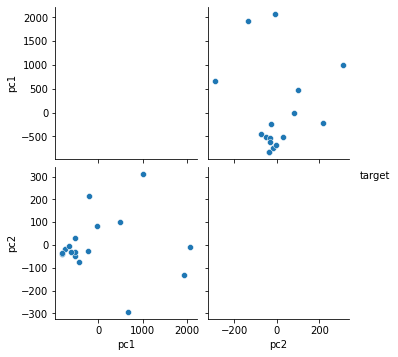

Auto-valores:
[844816.76566963  17440.51405027]

Auto-vetores:
[[ 0.49015722  0.50726586  0.50423561  0.49817035]
 [ 0.28084203 -0.85947138  0.24821973  0.34759699]]

Variância explicada:
[0.97002291 0.02002529]



In [29]:
pca = apply_pca(X, 2)

* Ao aplicar o PCA e ver que um componente pode explicar 97% da variância (mesmo com dados tão parecidos em todas as colunas), procurei sobre como encontrar os correspondentes;
* A resposta é simples:
    * Passamos para o PCA-2 encontrado uma matriz identidade;
    * O resultado do PCA será os pesos (betas) do polinômio característico;
    * A varíavel que mais se alinhar com o PC tem a melhor representação do mesmo

In [56]:
i = np.identity(X.shape[1])  # identity matrix
coef = pca.transform(i)
pd.DataFrame(np.abs(coef), columns=['PC-1', 'PC-2'], index=X.columns)

,PC-1,PC-2
Object 1,930.920796,51.501570
Object 2,930.903688,52.641884
Object 3,930.906718,51.534193
Object 4,930.912783,51.434815


* Ao mudarmos da base canônica para a base composta pelos 2 componentes principais e plotarmos o resultado dos componentes principais, podemos identificar alguns pontos (ou equipamentos) agindo como outliers na base:

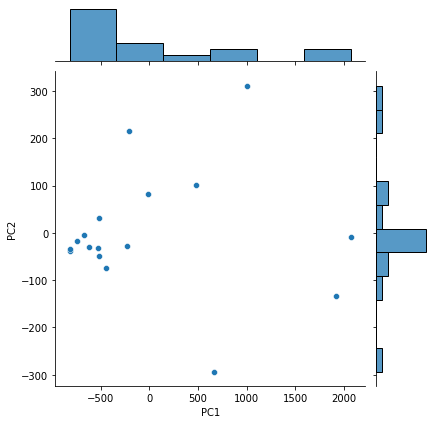

In [70]:
pca_df=pd.DataFrame(pca.transform(X), columns=['PC1', 'PC2'], index=X.index)
pca_df['equipment'] = X.index
sns.jointplot(x=pca_df.PC1, y=pca_df.PC2, kind='scatter')

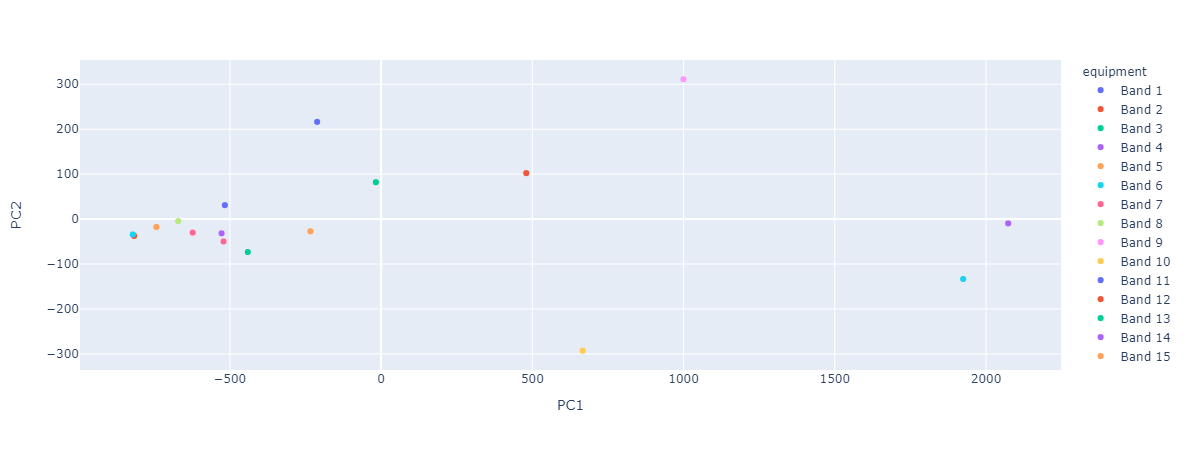

In [71]:
import plotly.express as px
fig = px.scatter(pca_df, x="PC1", y="PC2", color='equipment')
fig.show()

* como podemos definir um equipamento com comportamento errático?
    * Primeira ideia foi dividir em clusters - vamos utilizar o método Elbow:
        * Nele, plotamos o somatório da variância dos dados em relação ao número dos clusters;
        * Onde a distância dos erros quadráticos ficar mais estável, teríamos uma melhor definição do cluster, onde não existe uma discrepância tão grande em termos de variância

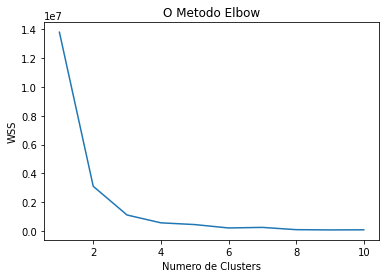

In [83]:
from sklearn.cluster import KMeans
wcss = []
kmeans_df = pca_df.drop('equipment',axis=1)
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(kmeans_df)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

* Os Números de 4 e 5 Clusters parecem ter resultados interessantes - vamos aplicar 5, por conveniência:

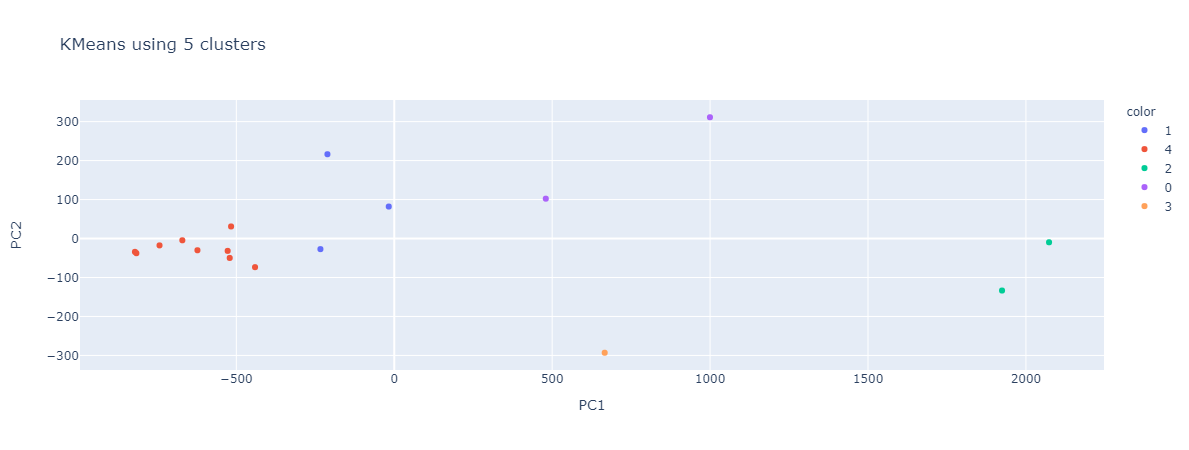

In [103]:
from sklearn.cluster import KMeans

kmeans = KMeans(5, init = 'random')
kmeans.fit(kmeans_df)
labels = [str(label) for label in kmeans.labels_]
fig = px.scatter(pca_df, x="PC1", y="PC2", color=labels, title='KMeans using {} clusters'.format(n_clusters))
fig.show()

In [108]:
pca_df['cluster'] = labels
pca_df.cluster.value_counts()

4    9
1    3
0    2
2    2
3    1
Name: cluster, dtype: int64

In [118]:
pca_df.query('cluster == "3"')

,PC1,PC2,equipment,cluster
Band 10,666.30612,-293.117951,Band 10,3


In [120]:
df.query('index=="Band 10"')

,Object 1,Object 2,Object 3,Object 4,target
Band 10,720,1033,566,874,1


### O equipamento, portanto, seria o Band 10 - de acordo com a análise!
---

Referências:

[Artigo original em inglês](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

[Imagem original do pássaro mineiro barulhento](https://pixabay.com/pt/photos/p%C3%A1ssaro-mineiro-barulhento-4580638/)

[Arquivo CSV do dataset IRIS](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/)

[K-Means Clustering - squared Euclidean Distances!](https://en.wikipedia.org/wiki/K-means_clustering)

[K-Means Clustering - kdnuggets](https://www.kdnuggets.com/2021/08/mastering-clustering-segmentation-problem.html)